In [7]:
import numpy as np
import control as ctrl
import matplotlib.pyplot as plt

from get_kr import get_kr

In [8]:
def factorial(n):
    if n == 0:
        return 1
    else:
        return n*factorial(n-1)

In [9]:
def nchoosek(n, k):
    return int(factorial(n)/(factorial(k)*factorial(n-k)))

In [10]:
def lyapunov(lamb,N):
    S = np.zeros((N,N))

    for k in range(1,N+1):
        for l in range(1,N+1):
            c = nchoosek(l+k-2,k-1)
            S[l-1][k-1] = ((-1)**(l+k)*c)/lamb**(l+k-1)

    return S

eig =  [0. 0. 0.]


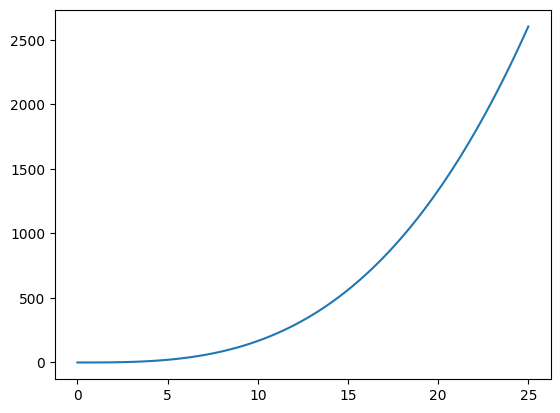

|U| =  1.0
|V| =  -1.0
K =  [[5. 9. 5.]]
[-2.+1.j -2.-1.j -1.+0.j]
kr =  [[5.]]


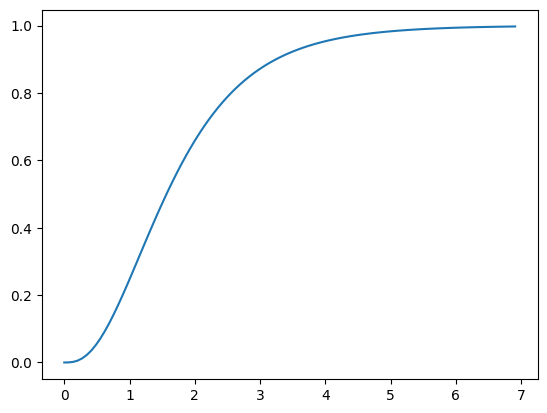

L =  [[ 6. 11.  6.]]


In [34]:
# Planta nominal
A = np.array([[0, 0, 0],
              [1, 0, 0],
              [0, 1, 0]])

B = np.array([[1],
              [0],
              [0]])

C = np.array([[0, 0, 1]])

D = 0

# Pasos previos al disenio del controlador
# A. Estabilidad del sistema
print("eig = ", np.linalg.eigvals(A))

# B. Respuesta ante una entrada tipo escalon
sys_ss = ctrl.ss(A, B, C, D) # Sistema en lazo abierto
t_la, y_la = ctrl.step_response(sys_ss)

plt.figure()
plt.plot(t_la, y_la)
plt.show()

## Metodologia para el disenio de un ctrl por retro de estados
## basado en observador

# 1. Verificamos controlabilidad
U = ctrl.ctrb(A, B)

print("|U| = ", np.linalg.det(U))

# 2. Verificamos observabilidad
V = ctrl.obsv(A, C)

print("|V| = ", np.linalg.det(V))

# 3. Disenio del controlador
eig_d_K = [-1, -2 + 1j, -2 - 1j]
K = ctrl.place(A, B, eig_d_K)
print("K = ", K)

# 4. Verificamos eigenvalores del sistema en lc
print(np.linalg.eigvals(A - B*K))

# 5. Calculamos la constante kr
kr = get_kr(sys_ss, K)
print("kr = ", kr)

# 6. Simulamos el control por retroalimentacion de estados
Alc = A - B*K
Blc = B*kr

sys_lc_K = ctrl.ss(Alc, Blc, C, D)

t, y = ctrl.step_response(sys_lc_K)

plt.figure
plt.plot(t, y)
plt.show()

# 7. Disenio del observador
eig_d_L = [-3, -2, -1]
L = ctrl.place(A.T, C.T, eig_d_L)
# Localizacion de eigenvalores no es posible porque existe
# una singularidad debido a A

# 7a. Disenio del observador via Lyapunov
#lamda = 0.5
#L = lyapunov(lamda, 3)

print("L = ", L)

/tmp/ipykernel_2763/14941066.py:27: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  u[k] = -(K[0,0]*x1_g[k] + K[0,1]*x2_g[k] + K[0,2]*x3_g[k]) + kr*ref[k]


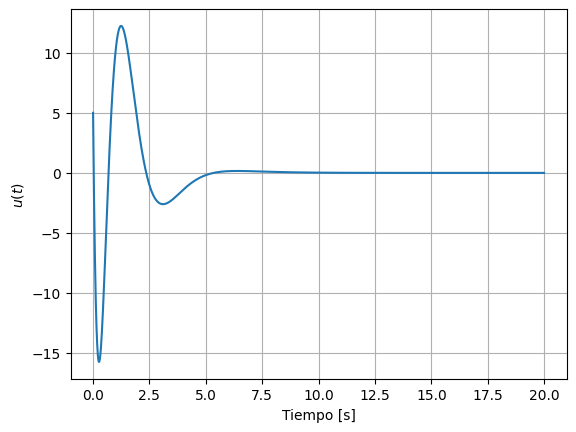

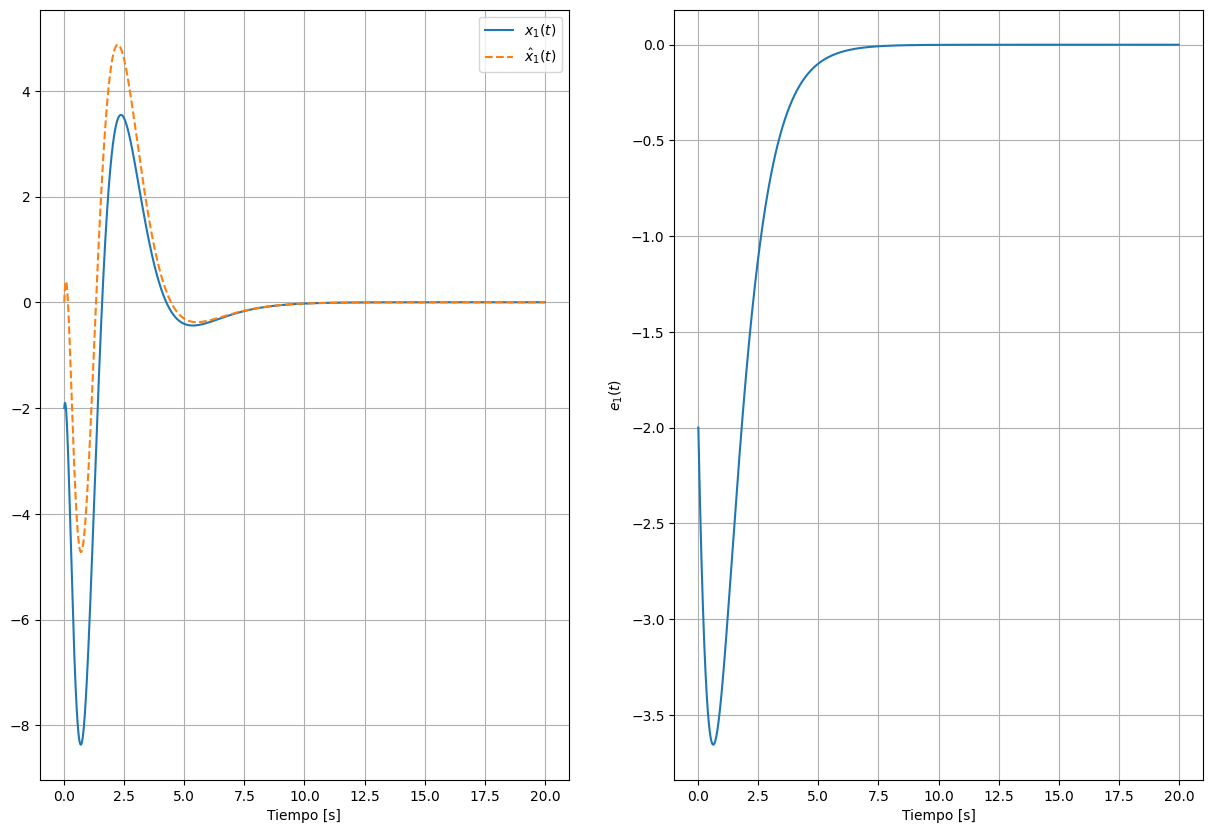

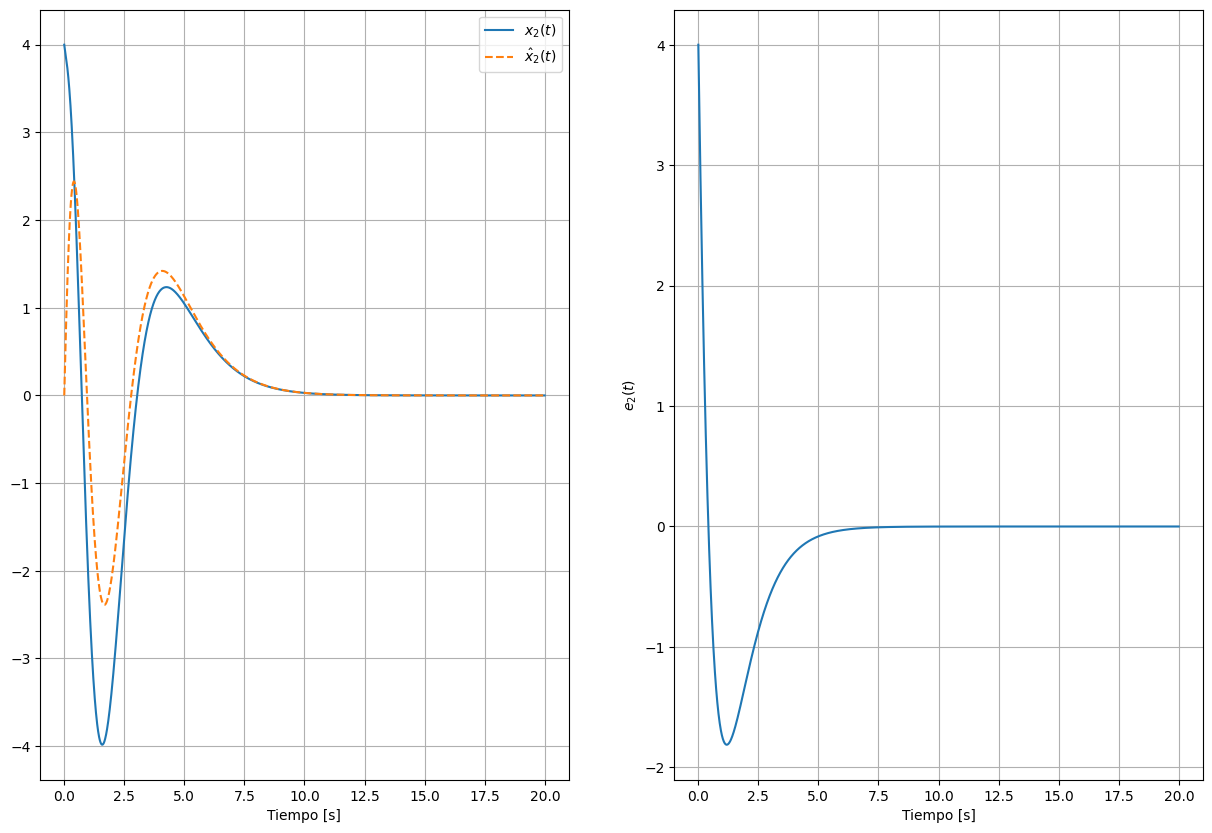

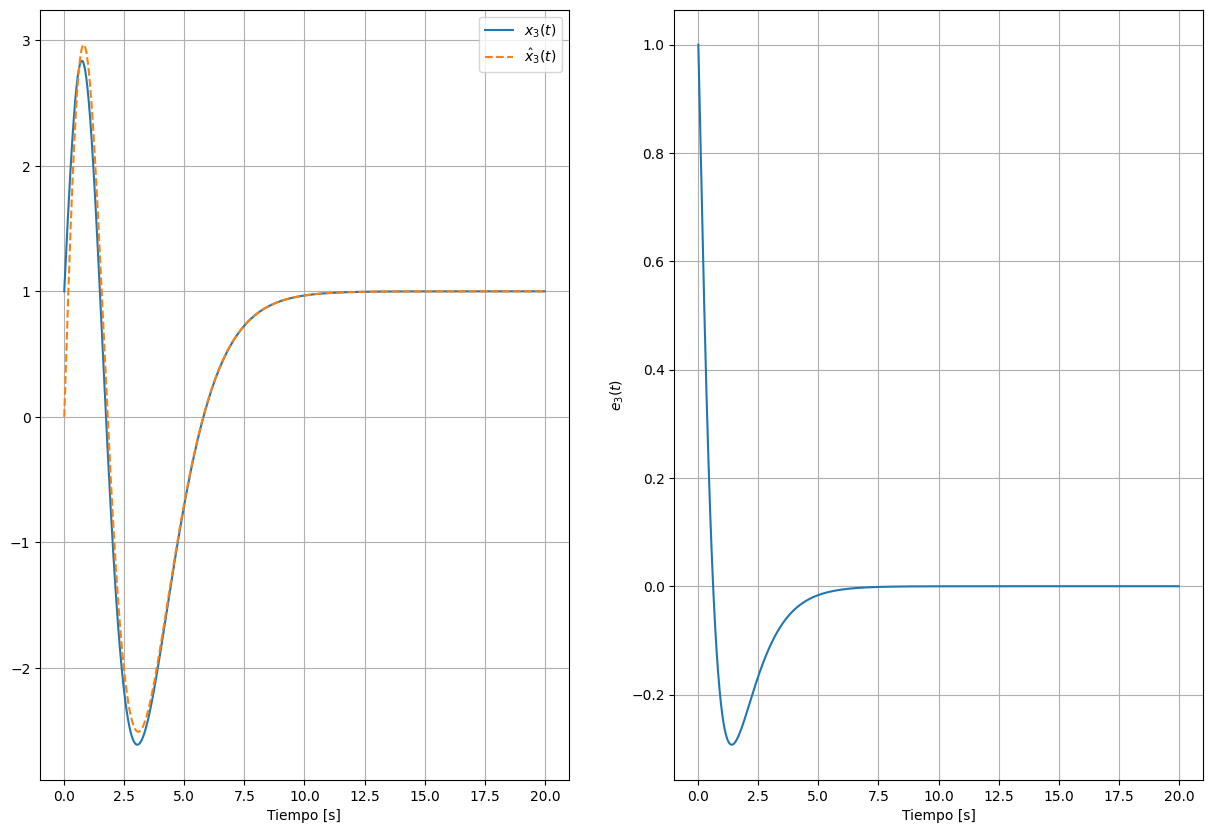

In [35]:
# 8. Simulacion del esquema de control por retro de estados
# basado en observador

# Parametros de simulacion
h = 1e-2
tfin = 20
N = int(np.ceil((tfin -h)/h))
t = h + np.arange(0, N)*h

# Referencia
ref = np.ones(N)

u = np.zeros(N)

x0 = [-2, 4, 1]
x1 = np.hstack((x0[0], np.zeros(N-1)))
x2 = np.hstack((x0[1], np.zeros(N-1)))
x3 = np.hstack((x0[2], np.zeros(N-1)))

x0_g = [0, 0, 0]
x1_g = np.hstack((x0_g[0], np.zeros(N-1)))
x2_g = np.hstack((x0_g[1], np.zeros(N-1)))
x3_g = np.hstack((x0_g[2], np.zeros(N-1)))

for k in range(N-1):
    # Entrada de control
    u[k] = -(K[0,0]*x1_g[k] + K[0,1]*x2_g[k] + K[0,2]*x3_g[k]) + kr*ref[k]

    # Planta
    x1[k+1] = x1[k] + h*( u[k] )
    x2[k+1] = x2[k] + h*( x1[k] )
    x3[k+1] = x3[k] + h*( x2[k] )

    # Observador
    x1_g[k+1] = x1_g[k] + h*( u[k] + L[0,0]*(x3[k] - x3_g[k]) )
    x2_g[k+1] = x2_g[k] + h*( x1_g[k] + L[0,1]*(x3[k] - x3_g[k]) )
    x3_g[k+1] = x3_g[k] + h*( x2_g[k] + L[0,2]*(x3[k] - x3_g[k]) )


plt.figure()
plt.plot(t, u)
plt.grid('on')
plt.ylabel('$u(t)$')
plt.xlabel('Tiempo [s]')
plt.show()

fig, ax = plt.subplots(1, 2, figsize = (15, 10))
ax[0].plot(t, x1, label = '$x_1(t)$')
ax[0].plot(t, x1_g, '--', label = '$\hat{x}_1(t)$')
ax[0].legend()
ax[0].grid('on')
ax[0].set_xlabel('Tiempo [s]')

ax[1].plot(t, x1 - x1_g)
ax[1].set_ylabel('$e_{1}(t)$')
ax[1].set_xlabel('Tiempo [s]')
ax[1].grid('on')
plt.show()

fig, ax = plt.subplots(1, 2, figsize = (15, 10))
ax[0].plot(t, x2, label = '$x_2(t)$')
ax[0].plot(t, x2_g, '--', label = '$\hat{x}_2(t)$')
ax[0].legend()
ax[0].grid('on')
ax[0].set_xlabel('Tiempo [s]')

ax[1].plot(t, x2 - x2_g)
ax[1].set_ylabel('$e_{2}(t)$')
ax[1].set_xlabel('Tiempo [s]')
ax[1].grid('on')
plt.show()

fig, ax = plt.subplots(1, 2, figsize = (15, 10))
ax[0].plot(t, x3, label = '$x_3(t)$')
ax[0].plot(t, x3_g, '--', label = '$\hat{x}_3(t)$')
ax[0].legend()
ax[0].grid('on')
ax[0].set_xlabel('Tiempo [s]')

ax[1].plot(t, x3 - x3_g)
ax[1].set_ylabel('$e_{3}(t)$')
ax[1].set_xlabel('Tiempo [s]')
ax[1].grid('on')
plt.show()